In [ ]:
!pip install opencv-python dlib numpy

so the way this is going to work is that it will be a two step process

i will use the cv2 and dlib and numpy libraries to extract certain facial features

based on [paper1],[paper2], and [paper3] the following features are important in the human perception of attractiveness

wider-set eyes - measured by interpupilary distance
triangular face - measured by Midface ratio
proportional lower third - measured by Chin to philtrum ratio
angle of eyes - measured by Canthal tilt
proportional middle third - Mouth to nose ratio
jaw width - measured by Bigonial width
lip evenness - measured by lip ratio
overall size of lower third of face - lower third height
measure of eye size - Palpebral fissure length


interpupilary distance
midface ratio
chin to philtrum ratio
mouth to nose ratio
bigonal width
lip ratio
lower third height
palpebral fissure length
Eye separation ratio
Eye to mouth angle
Eyebrow distance

so once these are filtered through, i will put them together, and then use
reference statistics in order to train a custom model/classifier that takes in these numbers and more if i find them
and produces a score for the given image.

probably i will end up using some sort of unsupervised learning model


In [ ]:
!pwd

/content


In [17]:
!wget -c https://huggingface.co/spaces/asdasdasdasd/Face-forgery-detection/resolve/ccfc24642e0210d4d885bc7b3dbc9a68ed948ad6/shape_predictor_68_face_landmarks.dat?download=true -O /shape_predictor_68_face_landmarks.dat

--2024-05-01 16:17:58--  https://huggingface.co/spaces/asdasdasdasd/Face-forgery-detection/resolve/ccfc24642e0210d4d885bc7b3dbc9a68ed948ad6/shape_predictor_68_face_landmarks.dat?download=true
Resolving huggingface.co (huggingface.co)... 18.155.68.4, 18.155.68.99, 18.155.68.111, ...
Connecting to huggingface.co (huggingface.co)|18.155.68.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/fc/8f/fc8fdd1edac6c2dd10eba239245ef331f010fa9491b0003fee03a07be2909850/fbdc2cb80eb9aa7a758672cbfdda32ba6300efe9b6e6c7a299ff7e736b11b92f?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27shape_predictor_68_face_landmarks.dat%3B+filename%3D%22shape_predictor_68_face_landmarks.dat%22%3B&Expires=1714839478&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNDgzOTQ3OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mYy84Zi9mYzhmZGQxZWRhYzZjMmRkMTBlYmEyMzkyNDVlZjMzMWYw

Saving IMG_4028.jpg to IMG_4028 (1).jpg
face detected


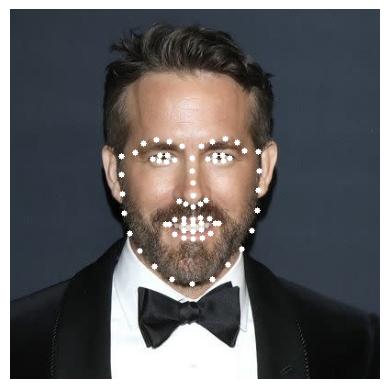

In [18]:
import cv2
import dlib
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np


uploaded = files.upload()


if len(uploaded) == 1:
    image_path = next(iter(uploaded))
    # Load the uploaded image
    image = cv2.imread(image_path)
    # Convert color from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize the dlib face detector
    detector = dlib.get_frontal_face_detector()
    #68-point facial predictor
    #this grabs the face bounding box supplied from the detector, and detects the
    #incidences of 68 different facial landmarks to be used in the next step
    predictor = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")


    # Detect faces in the grayscale image
    faces = detector(image_rgb)

    # Iterate over detected faces
    for face in faces:
        print("face detected")
        # Extract facial landmarks
        landmarks = predictor(image_rgb, face)

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image_rgb, (x, y), 3, (255, 255, 255), -1)

        # Convert landmarks to numpy array
        landmarks_np = np.array([(p.x, p.y) for p in landmarks.parts()])

    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [ ]:
#benchmarks for the face

#interocular distance - facial size (horizontal)

def interpupilary_distance(landmarks_np):
  left_eye = landmarks_np[36:42]
  right_eye = landmarks_np[42:48]
  left_eye_center = np.mean(left_eye, axis=0)
  right_eye_center = np.mean(right_eye, axis=0)
  interpupillary_distance = np.linalg.norm(left_eye_center - right_eye_center)

  # Estimate bizygomatic width using outer eye corners
  zygomatic_left = landmarks_np[0]  # Assuming landmark 0 is at the left zygomatic bone
  zygomatic_right = landmarks_np[16]  # Assuming landmark 16 is at the right zygomatic bone
  bizygomatic_width = np.linalg.norm(zygomatic_left - zygomatic_right)

  # Calculate the ratio of interpupillary distance to bizygomatic width
  attractiveness_index = interpupillary_distance / bizygomatic_width

  return attractiveness_index
#print(f"interpupilary distance: {interpupilary_distance}")

def interocular_distance(landmarks_np):
  left_eye_outer = landmarks_np[36]  # outer corner of the left eye
  right_eye_outer = landmarks_np[45]  # outer corner of the right eye
  interocular_distance = np.linalg.norm(left_eye_outer - right_eye_outer)
  #cv2.line(image_rgb, tuple(left_eye_outer.astype(int)), tuple(right_eye_outer.astype(int)), (0, 0, 255), 2)
  return interocular_distance


#total facial distance - facial size (vertical)
def facial_distance_vertical(landmarks_np):
  highest_left = landmarks_np[19]  #highest left eyebrow
  highest_right = landmarks_np[24] #highest right eyebrow
  forehead = (highest_left + highest_right) / 2
  chin = landmarks_np[8]
  facial_distance_vertical = np.linalg.norm(forehead - chin)
  #cv2.line(image_rgb, tuple(forehead.astype(int)), tuple(chin.astype(int)), (255, 0, 0), 4)
  return facial_distance_vertical

#plt.imshow(image_rgb)
#plt.axis('off')
#plt.show()

In [ ]:

def midface_ratio(landmarks_np):
  eye_center = np.mean(landmarks_np[36:48], axis=0)
  nose_tip = landmarks_np[30]
  chin = landmarks_np[8]
  midface_ratio = np.linalg.norm(eye_center - nose_tip) / np.linalg.norm(nose_tip - chin)
  #cv2.line(image_rgb, tuple(eye_center.astype(int)), tuple(nose_tip.astype(int)), (255, 0, 0), 2)  # Red line from eyes to nose
  #cv2.line(image_rgb, tuple(nose_tip.astype(int)), tuple(chin.astype(int)), (0, 255, 0), 2)  # Green line from nose to chin
  #print(midface_ratio)
  return midface_ratio

In [ ]:
def calculate_angle(p1, p2, p3):
  #calculating a threepoint angle
  v1 = p1 - p2
  v2 = p3 - p2
  angle_rad = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
  angle_deg = np.degrees(angle_rad)
  return angle_deg

In [ ]:
# Mouth to nose ratio
def mouth_to_nose_ratio(landmarks_np, facial_distance_vertical):
  nose_tip = landmarks_np[30]
  mouth_center = np.mean(landmarks_np[48:68], axis=0)
  #cv2.line(image_rgb, tuple(mouth_center.astype(int)), tuple(nose_tip.astype(int)), (255, 255, 0), 2)  # Yellow line from mouth to nose
  # Calculate the mouth to nose ratio
  mouth_to_nose_distance = np.linalg.norm(mouth_center - nose_tip)
  mouth_to_nose_ratio = mouth_to_nose_distance / facial_distance_vertical
  return mouth_to_nose_ratio


In [ ]:
# Bigonal width
def bigonal_width(landmarks_np):
  left_gonion = landmarks_np[0]  # Left side of the face (approximation)
  right_gonion = landmarks_np[16]  # Right side of the face (approximation)
  bigonal_width = np.linalg.norm(left_gonion - right_gonion)
  #cv2.line(image_rgb, tuple(left_gonion.astype(int)), tuple(right_gonion.astype(int)), (0, 0, 255), 2)  # Blue line between cheekbones
  return bigonal_width

In [ ]:
# Lip ratio
def lip_ratio(landmarks_np):
  chin = landmarks_np[8]
  mouth_center = np.mean(landmarks_np[48:68], axis=0)
  upper_lip = np.mean(landmarks_np[48:55], axis=0)
  lower_lip = np.mean(landmarks_np[55:60], axis=0)
  lip_ratio = np.linalg.norm(upper_lip - lower_lip) / np.linalg.norm(mouth_center - chin)
  return lip_ratio

In [ ]:
# Lower third height
def lower_third_height(landmarks_np):
  nose_tip = landmarks_np[30]
  chin = landmarks_np[8]
  nose_to_chin_height = np.linalg.norm(nose_tip - chin)
  lower_third_height = nose_to_chin_height / facial_distance_vertical(landmarks_np)
  return lower_third_height

In [ ]:
# canthal tilt
def canthal_tilt(landmarks_np):
    def calculate_tilt(inner, outer):
        # Calculate the difference between inner and outer points
        delta = outer - inner
        # Calculate the angle in degrees using arctan2
        angle = np.degrees(np.arctan2(delta[1], delta[0]))
        return angle

    # Eye landmarks for the left and right eyes
    left_eye_inner = landmarks_np[39]
    left_eye_outer = landmarks_np[36]
    right_eye_inner = landmarks_np[42]
    right_eye_outer = landmarks_np[45]

    # Calculate canthal tilt for both eyes
    left_eye_tilt = calculate_tilt(left_eye_inner, left_eye_outer)
    right_eye_tilt = calculate_tilt(right_eye_inner, right_eye_outer)

    # Compute the average canthal tilt
    average_tilt = (left_eye_tilt + right_eye_tilt) / 2
    return average_tilt

In [ ]:
# Eye separation ratio
def facial_symmetry(landmarks_np, bigonal_width_val):
    # Define points for outer corners of eyes
    left_eye_outer = landmarks_np[36]
    right_eye_outer = landmarks_np[45]

    # Define a midpoint on the face, typically between the eyes
    midpoint = (landmarks_np[39] + landmarks_np[42]) / 2

    # Calculate distances from the midpoint to each outer eye corner
    dist_left = np.linalg.norm(left_eye_outer - midpoint)
    dist_right = np.linalg.norm(right_eye_outer - midpoint)

    # Calculate symmetry as the absolute difference between these distances, normalized by face width
    symmetry_index = abs(dist_left - dist_right) / bigonal_width_val
    return symmetry_index

In [ ]:
def jawline_angle(landmarks_np):
  chin_left = landmarks_np[7]
  chin = landmarks_np[8]
  chin_right = landmarks_np[9]
  jawline_angle = calculate_angle(chin_left, chin, chin_right)
  #cv2.line(image_rgb, tuple(chin_left.astype(int)), tuple(chin.astype(int)), (0, 255, 255), 2)
  #cv2.line(image_rgb, tuple(chin.astype(int)), tuple(chin_right.astype(int)), (0, 255, 255), 2)
  return jawline_angle

In [ ]:
def eye_to_mouth_angle(landmarks_np):
  left_eye = landmarks_np[36:42]
  right_eye = landmarks_np[42:48]
  mouth_center = np.mean(landmarks_np[48:68], axis=0)
  left_eye_center = np.mean(left_eye, axis=0)
  right_eye_center = np.mean(right_eye, axis=0)
  eye_to_mouth_vector = mouth_center - (left_eye_center + right_eye_center) / 2
  eye_to_mouth_angle = np.arctan2(eye_to_mouth_vector[1], eye_to_mouth_vector[0]) * 180 / np.pi
  return eye_to_mouth_angle

In [ ]:
def eyebrow_distance(landmarks_np):
  left_eyebrow_inner = landmarks_np[17]
  right_eyebrow_inner = landmarks_np[22]
  eyebrow_distance = np.linalg.norm(left_eyebrow_inner - right_eyebrow_inner)
  return eyebrow_distance

In [ ]:
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def cheek_fullness_index(landmarks_np):
    # Points on the jawline near the cheeks
    jaw_left = landmarks_np[3]
    jaw_right = landmarks_np[13]

    # Cheek points (can be the most protruding part on the zygomatic bone)
    cheek_left = landmarks_np[31]
    cheek_right = landmarks_np[35]

    # Calculate cheek fullness as the sum of normalized distances from jaw to cheek points
    fullness_left = calculate_distance(cheek_left, jaw_left)
    fullness_right = calculate_distance(cheek_right, jaw_right)

    # Normalizing by the distance between the two jaw points to account for face size
    jaw_width = calculate_distance(jaw_left, jaw_right)
    fullness_index = (fullness_left + fullness_right) / jaw_width

    return fullness_index


In [ ]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
import cv2
import dlib
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


def get_landmarks(image):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Initialize the dlib face detector
  detector = dlib.get_frontal_face_detector()
    #68-point facial predictor
    #this grabs the face bounding box supplied from the detector, and detects the
    #incidences of 68 different facial landmarks to be used in the next step
  predictor = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")


    # Detect faces in the grayscale image
  faces = detector(image_rgb)

    # Iterate over detected faces
  if len(faces) == 0:
      print("NO FACE DETECTED")
      return None
  for face in faces:
        # Extract facial landmarks
      landmarks = predictor(image_rgb, face)

      for n in range(0, 68):
          x = landmarks.part(n).x
          y = landmarks.part(n).y
          cv2.circle(image_rgb, (x, y), 3, (255, 255, 255), -1)

        # Convert landmarks to numpy array
      landmarks_np = np.array([(p.x, p.y) for p in landmarks.parts()])
  return landmarks_np





columns = [
    "Interpupillary Distance", "Interocular Distance", "Midface Ratio", "Jawline Angle",
    "Cheekbone Angle Left", "Cheekbone Angle Right",
    "Mouth to Nose Ratio", "Bigonal Width", "Lip Ratio", "Lower Third Height",
    "Palpebral Fissure Length", "Eye Separation Ratio", "Eye to Mouth Angle", "Eyebrow Distance"
]




data = pd.DataFrame(columns=columns)


directory_path = './drive/MyDrive/Humans/'
image_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.jpg') or f.endswith('.PNG')]

index = 0
for path in image_paths:
    print(f"Picture {index} at {path}")
    image = cv2.imread(path)
    # Assume function 'get_landmarks' returns numpy array of landmarks
    landmarks = get_landmarks(image)
    if landmarks is None:
      continue
   # Compute each measurement
    interpupillary_distance_val = interpupilary_distance(landmarks)
    midface_ratio_val = midface_ratio(landmarks)
    interocular_distance_val = interocular_distance(landmarks)
    jawline_angle_val = jawline_angle(landmarks)
    fullness_index = cheek_fullness_index(landmarks)
    mouth_to_nose_ratio_val = mouth_to_nose_ratio(landmarks, facial_distance_vertical(landmarks))
    bigonal_width_val = bigonal_width(landmarks)
    lip_ratio_val = lip_ratio(landmarks)
    lower_third_height_val = lower_third_height(landmarks)
    canthal_tilt = canthal_tilt(landmarks)
    facial_symmetry_rank = facial_symmetry(landmarks, bigonal_width_val)
    eye_to_mouth_angle_val = eye_to_mouth_angle(landmarks)
    eyebrow_distance_val = eyebrow_distance(landmarks)

    # Create a row with all the computed metrics
    row = {
        "Interpupillary Distance": interpupillary_distance_val,
        "Midface Ratio": midface_ratio_val,
        "Interocular Distance": interocular_distance_val,
        "Jawline Angle": jawline_angle_val,
        "Fullness Index": fullness_index,
        "Mouth to Nose Ratio": mouth_to_nose_ratio_val,
        "Bigonal Width": bigonal_width_val,
        "Lip Ratio": lip_ratio_val,
        "Lower Third Height": lower_third_height_val,
        "Canthal Tilt": canthal_tilt,
        "Facial Symmetry Rank": facial_symmetry_rank,
        "Eye to Mouth Angle": eye_to_mouth_angle_val,
        "Eyebrow Distance": eyebrow_distance_val
    }


    # Append row to the DataFrame
    new_row_df = pd.DataFrame([row])  # Make a DataFrame from the row dictionary
    data = pd.concat([data, new_row_df], ignore_index=True)
    index += 1

data

Picture 0 at ./drive/MyDrive/Humans/1 (6402).jpg
Picture 1 at ./drive/MyDrive/Humans/1 (6467).jpg
Picture 2 at ./drive/MyDrive/Humans/1 (6446).jpg
Picture 3 at ./drive/MyDrive/Humans/1 (6436).jpg
Picture 4 at ./drive/MyDrive/Humans/1 (6430).jpg
Picture 5 at ./drive/MyDrive/Humans/1 (6450).jpg
Picture 6 at ./drive/MyDrive/Humans/1 (643).jpg
Picture 7 at ./drive/MyDrive/Humans/1 (64).jpg
Picture 8 at ./drive/MyDrive/Humans/1 (6412).jpg
Picture 9 at ./drive/MyDrive/Humans/1 (6475).jpg
Picture 10 at ./drive/MyDrive/Humans/1 (6385).jpg
Picture 11 at ./drive/MyDrive/Humans/1 (6452).jpg
Picture 12 at ./drive/MyDrive/Humans/1 (6449).jpg
Picture 13 at ./drive/MyDrive/Humans/1 (646).jpg
Picture 14 at ./drive/MyDrive/Humans/1 (644).jpg
Picture 15 at ./drive/MyDrive/Humans/1 (6404).jpg
Picture 16 at ./drive/MyDrive/Humans/1 (6479).jpg
Picture 17 at ./drive/MyDrive/Humans/1 (6415).jpg
Picture 18 at ./drive/MyDrive/Humans/1 (6400).jpg
Picture 19 at ./drive/MyDrive/Humans/1 (6455).jpg
Picture 20 at .

KeyboardInterrupt: 

In [ ]:

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

# Normalize the data
normalized_data = (data - data.mean()) / data.std()
normalized_data

,Interpupillary Distance,Interocular Distance,Midface Ratio,Jawline Angle,Cheekbone Angle Left,Cheekbone Angle Right,Mouth to Nose Ratio,Bigonal Width,Lip Ratio,Lower Third Height,Palpebral Fissure Length,Eye Separation Ratio,Eye to Mouth Angle,Eyebrow Distance
0,-0.117505,-0.190911,-0.994600,1.677478,0.057626,0.810924,0.080788,-0.054172,-2.356319,0.813670,-0.390551,0.955280,-0.917636,-0.026033
1,-0.679133,-0.663772,-0.113797,0.047018,-2.273828,4.645136,1.543021,-0.429432,-0.460341,1.668681,-0.648957,-2.423198,-0.712896,-0.295123
2,-0.634351,-0.601825,-0.514545,-2.320249,-2.227401,2.830660,1.522528,-0.332263,-1.167138,1.484949,-0.541730,-3.052405,-1.838195,-0.123865
3,-0.208538,-0.201702,-0.255663,-1.289555,-1.043864,1.484389,-0.549670,-0.177824,-0.813975,0.375677,-0.180270,-0.397372,0.009940,-0.013739
4,-0.379713,-0.354736,0.199325,-1.403722,1.669963,-1.067594,-0.658464,-0.253287,0.041763,-0.117820,-0.275572,-1.667780,0.999663,-0.564690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,-0.335814,-0.317929,-0.326615,1.149691,0.925481,0.234428,0.645178,-0.353565,1.320842,0.218196,-0.260584,-0.431193,-0.215679,-0.394769
2744,-0.337715,-0.349899,-0.481448,0.837708,-0.384256,-0.058756,0.802876,-0.360334,-1.829901,0.717571,-0.394577,0.520875,-0.331109,-0.317163
2745,-0.789809,-0.793779,0.061076,0.342070,-0.331762,0.211957,0.089578,-0.832795,-0.335168,-0.353173,-0.796045,0.322457,0.287259,-0.719656
2746,0.081347,0.041811,1.821379,1.221796,0.930626,1.593222,-1.386166,-0.148960,-0.887000,-1.282482,-0.059501,2.507063,0.231257,-0.142056


from matplotlib import pyplot as plt
normalized_data['Interpupillary Distance'].plot(kind='hist', bins=20, title='Interpupillary Distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
normalized_data['Interocular Distance'].plot(kind='hist', bins=20, title='Interocular Distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
normalized_data['Midface Ratio'].plot(kind='hist', bins=20, title='Midface Ratio')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
normalized_data['Jawline Angle'].plot(kind='hist', bins=20, title='Jawline Angle')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
normalized_data.plot(kind='scatter', x='Interpupillary Distance', y='Interocular Distance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
normalized_data.plot(kind='scatter', x='Interocular Distance', y='Midface Ratio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
normalized_data.plot(kind='scatter', x='Midface Ratio', y='Jawline Angle', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
normalized_data.plot(kind='scatter', x='Jawline Angle', y='Cheekbone Angle Left', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
normalized_data['Interpupillary Distance'].plot(kind='line', figsize=(8, 4), title='Interpupillary Distance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
normalized_data['Interocular Distance'].plot(kind='line', figsize=(8, 4), title='Interocular Distance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
normalized_data['Midface Ratio'].plot(kind='line', figsize=(8, 4), title='Midface Ratio')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
normalized_data['Jawline Angle'].plot(kind='line', figsize=(8, 4), title='Jawline Angle')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
normalized_data.to_csv("normalized_data.csv")

In [ ]:



# Cluster data
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(normalized_data)
data['Cluster'] = clusters
cluster_indices = {i: data.index[data['Cluster'] == i].tolist() for i in range(10)}
for cluster, indices in cluster_indices.items():
    print(f"Indices in Cluster {cluster}: {indices}")


# building the model
input_dim = normalized_data.shape[1]

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())  # normalize the activations of the first layer
model.add(Dropout(0.3))  # Randomly sets input units to 0 with a frequency of 30% at each step during training

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

# since the task is to rank, the output layer has 10 units corresponding to rankings 1-10
model.add(Dense(10, activation='softmax'))  # using softmax for classification

# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

clusters = np.array(clusters)

# train the model
model.fit(normalized_data, clusters, epochs=50, batch_size=10, verbose=1)

loss, accuracy = model.evaluate(normalized_data, clusters)
print(f'Loss: {loss}, Accuracy: {accuracy}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Indices in Cluster 0: [5, 9, 11, 14, 16, 30, 32, 33, 37, 51, 55, 56, 59, 83, 88, 92, 104, 110, 124, 127, 132, 133, 136, 140, 165, 172, 181, 183, 190, 191, 199, 200, 201, 202, 205, 208, 215, 220, 221, 222, 226, 234, 243, 256, 260, 264, 279, 284, 286, 293, 300, 312, 318, 320, 323, 324, 334, 337, 354, 358, 361, 364, 366, 368, 383, 398, 399, 404, 408, 411, 427, 428, 429, 434, 440, 449, 456, 457, 465, 476, 477, 487, 490, 509, 514, 516, 521, 524, 525, 532, 553, 555, 558, 559, 567, 568, 580, 582, 590, 609, 621, 625, 627, 635, 639, 652, 657, 659, 665, 677, 679, 690, 734, 737, 739, 742, 750, 759, 762, 766, 770, 781, 787, 790, 798, 812, 823, 836, 849, 864, 867, 868, 876, 882, 884, 901, 903, 904, 908, 915, 917, 918, 920, 922, 927, 930, 944, 945, 946, 950, 952, 955, 961, 966, 970, 975, 978, 981, 985, 986, 999, 1001, 1005, 1008, 1009, 1017, 1019, 1021, 1027, 1028, 1029, 1032, 1037, 1048, 1052, 1062, 1065, 1097, 1098, 1109, 1114, 1115, 1116, 1122, 1124, 1126, 1128, 1129, 1131, 1139, 1142, 1144, 1149

In [ ]:
model.save('model_test_1.keras')

In [ ]:
uploaded = files.upload()


if len(uploaded) == 1:
    image_path = next(iter(uploaded))
    image = cv2.imread(image_path)


    # initialize the dlib face detector
    detector = dlib.get_frontal_face_detector()
    #68-point facial predictor
    #this grabs the face bounding box supplied from the detector, and detects the
    #incidences of 68 different facial landmarks to be used in the next step
    predictor = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")


    # detect faces in the grayscale image
    faces = detector(image_rgb)

    columns = [
        "Interpupillary Distance", "Interocular Distance", "Midface Ratio", "Jawline Angle",
        "Cheekbone Angle Left", "Cheekbone Angle Right",
        "Mouth to Nose Ratio", "Bigonal Width", "Lip Ratio", "Lower Third Height",
        "Palpebral Fissure Length", "Eye Separation Ratio", "Eye to Mouth Angle", "Eyebrow Distance"
    ]




    data2 = pd.DataFrame(columns=columns)

    landmarks = get_landmarks(image)
        # Convert landmarks to numpy array
    interpupillary_distance_val = interpupilary_distance(landmarks)
    midface_ratio_val = midface_ratio(landmarks)
    interocular_distance_val = interocular_distance(landmarks)
    jawline_angle_val = jawline_angle(landmarks)
    cheekbone_angle_left_val, cheekbone_angle_right_val = cheekbone_angles(landmarks)
    mouth_to_nose_ratio_val = mouth_to_nose_ratio(landmarks, facial_distance_vertical(landmarks))
    bigonal_width_val = bigonal_width(landmarks)
    lip_ratio_val = lip_ratio(landmarks)
    lower_third_height_val = lower_third_height(landmarks)
    palpebral_fissure_length_val = palpebral_fissure_length(landmarks)
    eye_separation_ratio_val = eye_separation_ratio(landmarks, bigonal_width_val)
    eye_to_mouth_angle_val = eye_to_mouth_angle(landmarks)
    eyebrow_distance_val = eyebrow_distance(landmarks)

    row = {
        ""
        "Interpupillary Distance": interpupillary_distance_val,
        "Midface Ratio": midface_ratio_val,
        "Interocular Distance": interocular_distance_val,
        "Jawline Angle": jawline_angle_val,
        "Cheekbone Angle Left": cheekbone_angle_left_val,
        "Cheekbone Angle Right": cheekbone_angle_right_val,
        "Mouth to Nose Ratio": mouth_to_nose_ratio_val,
        "Bigonal Width": bigonal_width_val,
        "Lip Ratio": lip_ratio_val,
        "Lower Third Height": lower_third_height_val,
        "Palpebral Fissure Length": palpebral_fissure_length_val,
        "Eye Separation Ratio": eye_separation_ratio_val,
        "Eye to Mouth Angle": eye_to_mouth_angle_val,
        "Eyebrow Distance": eyebrow_distance_val
    }


    new_row_df = pd.DataFrame([row])
    data2 = pd.concat([data2, new_row_df], ignore_index=True)
    normalized_data2 = (data2 - data.mean()) / data.std()
    #print(normalized_data2)
    normalized_data2 = normalized_data2.drop(columns=['Cluster'])
    input_features = normalized_data2.to_numpy()
    #print(input_features)
    predictions = model.predict(input_features)
    #print(predictions)
    weights = np.arange(1, predictions.shape[1] + 1)
    weighted_sum = np.sum(weights * predictions)


    print("Inference Result:", weighted_sum)






Saving IMG_4011.PNG to IMG_4011.PNG
1/1 [==============================] - 0s 15ms/step
Inference Result: 1.202941461454202


Now, that the initial preprocessing has finished, I will write a way to take the angular and landmark data to become a pandas dataframe, and write a quick fixture to allow this to process a large amount of images.

____________________________________________________
# NEW ARCHITECTURE: FOUND LABELLED TRAINING DATA
____________________________________________________

In [1]:
import pandas as pd



df = pd.read_csv('/content/drive/MyDrive/archive33/labels.txt', sep=" ", header=None, names=['filename', 'label'])

print(df.head())


     filename     label
0   CF437.jpg  2.883333
1  AM1384.jpg  2.466667
2  AM1234.jpg  2.150000
3  AM1774.jpg  3.750000
4   CF215.jpg  3.033333


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Split the data into testing and training

In [2]:
from sklearn.model_selection import train_test_split

# 4/5 in training rest in another one which ill split into testing and validation
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Training Set Size:", len(train_df))
print("Validation Set Size:", len(val_df))
print("Test Set Size:", len(test_df))

Training Set Size: 1599
Validation Set Size: 200
Test Set Size: 200


Create the model bruh create the model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


# initialize the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(350, 350, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 175x175x32

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 87x87x64

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 43x43x128

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 21x21x256

    Flatten(),  # flatten the output, 21*21*256 = 112896

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 350, 350, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 350, 350, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 175, 175, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 175, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 175, 175, 64)      256       
 chNormalization)                                                
                                                        

In [4]:
import cv2
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.preprocessing.image import ImageDataGenerator


def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image at: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  # try normalizing i dont know why it not working
    #return img
    return img

train_images = []

index = 0
for fname in train_df['filename']:
    file_path = f'/content/drive/MyDrive/archive33/Images/Images/{fname}'
    print(f"{file_path} loading {index}")
    img = load_image(file_path)
    if img is None:
      continue
    train_images.append(img)
    index += 1



# convert the list of images to a numpy array
train_images = np.array(train_images)
train_labels = train_df['label'].values

#augment data
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

val_images = np.array([load_image(f'/content/drive/MyDrive/archive33/Images/Images/{fname}') for fname in val_df['filename']])
val_labels = val_df['label'].values

/content/drive/MyDrive/archive33/Images/Images/CF541.jpg loading 0
/content/drive/MyDrive/archive33/Images/Images/AF456.jpg loading 1
/content/drive/MyDrive/archive33/Images/Images/CM528.jpg loading 2
/content/drive/MyDrive/archive33/Images/Images/CM386.jpg loading 3
/content/drive/MyDrive/archive33/Images/Images/AF1794.jpg loading 4
/content/drive/MyDrive/archive33/Images/Images/CM138.jpg loading 5
/content/drive/MyDrive/archive33/Images/Images/CM447.jpg loading 6
/content/drive/MyDrive/archive33/Images/Images/AF749.jpg loading 7
/content/drive/MyDrive/archive33/Images/Images/AM111.jpg loading 8
/content/drive/MyDrive/archive33/Images/Images/AM434.jpg loading 9
/content/drive/MyDrive/archive33/Images/Images/CF543.jpg loading 10
/content/drive/MyDrive/archive33/Images/Images/AM554.jpg loading 11
/content/drive/MyDrive/archive33/Images/Images/AM1817.jpg loading 12
/content/drive/MyDrive/archive33/Images/Images/AF949.jpg loading 13
/content/drive/MyDrive/archive33/Images/Images/AM721.jpg

In [5]:
# train the model
history = model.fit(train_generator, epochs=10, validation_data=(val_images, val_labels))


Epoch 1/10
50/50 [==============================] - 75s 1s/step - loss: 99.5552 - mean_absolute_error: 5.4485 - val_loss: 0.8558 - val_mean_absolute_error: 0.7284
Epoch 2/10
50/50 [==============================] - 52s 1s/step - loss: 9.2403 - mean_absolute_error: 2.3614 - val_loss: 1.0185 - val_mean_absolute_error: 0.7929
Epoch 3/10
50/50 [==============================] - 52s 1s/step - loss: 4.6819 - mean_absolute_error: 1.7407 - val_loss: 1.5380 - val_mean_absolute_error: 1.0502
Epoch 4/10
50/50 [==============================] - 52s 1s/step - loss: 3.6164 - mean_absolute_error: 1.5296 - val_loss: 4.1473 - val_mean_absolute_error: 1.9300
Epoch 5/10
50/50 [==============================] - 51s 1s/step - loss: 2.8911 - mean_absolute_error: 1.3757 - val_loss: 3.7725 - val_mean_absolute_error: 1.7931
Epoch 6/10
50/50 [==============================] - 53s 1s/step - loss: 2.7957 - mean_absolute_error: 1.3295 - val_loss: 3.1312 - val_mean_absolute_error: 1.6337
Epoch 7/10
50/50 [=========

In [6]:
model.save('mikeymodel2.keras')

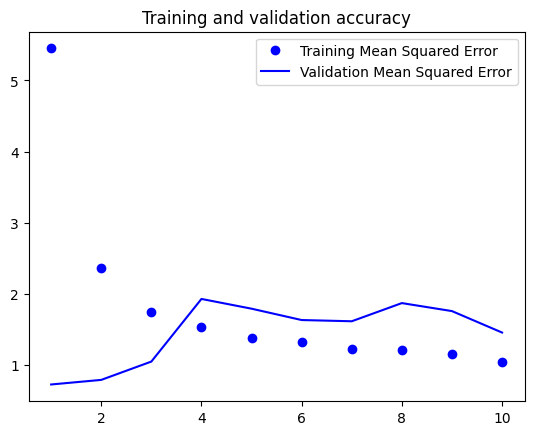

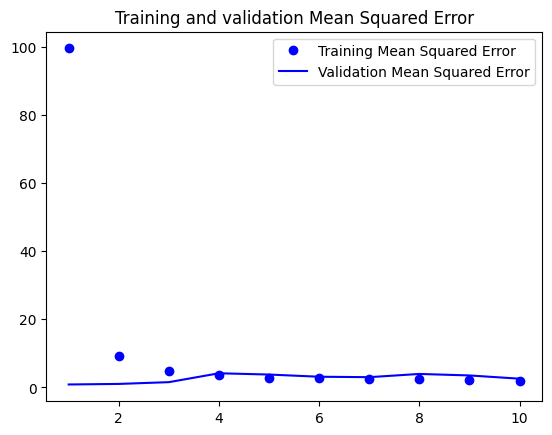

In [7]:
import matplotlib.pyplot as plt

acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# accuracy plot
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training Mean Squared Error')
plt.plot(epochs, val_acc, 'b', label='Validation Mean Squared Error')
plt.title('Training and validation accuracy')
plt.legend()

# loss plot
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Mean Squared Error')
plt.plot(epochs, val_loss, 'b', label='Validation Mean Squared Error')
plt.title('Training and validation Mean Squared Error')
plt.legend()

plt.show()


In [8]:
test_images = np.array([load_image(f'/content/drive/MyDrive/archive33/Images/Images/{fname}') for fname in test_df['filename']])
test_labels = test_df['label'].values

# testing time
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss}, Test Mean Squared Error: {test_accuracy}')


7/7 [==============================] - 0s 58ms/step - loss: 2.6551 - mean_absolute_error: 1.4717
Test Loss: 2.6550729274749756, Test Mean Squared Error: 1.4716905355453491


In [15]:
from google.colab import files
import cv2
import numpy as np
#from tensorflow.keras.models import load_model

# load and prepare the image
def prepare_image(image_path):
    # load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image at: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (350, 350))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


uploaded = files.upload()

image_path = next(iter(uploaded))

# prepare the image
prepared_image = prepare_image(image_path)

#model = load_model('mikeymikemodel.keras')

if prepared_image is not None:
    # Predict
    prediction = model.predict(prepared_image)
    print("Predicted Attractiveness Score:", prediction[0][0])
else:
    print("Image preparation failed.")


Saving IMG_4034.jpg to IMG_4034.jpg
1/1 [==============================] - 0s 20ms/step
Predicted Attractiveness Score: 4.4165473


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import numpy as np

def lr_time_based_decay(epoch, lr):
    decay = 0.001
    return lr * 1 / (1 + decay * epoch)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(350, 350, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 175x175x32

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 87x87x64

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 42x42x128

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 20x20x256
    #wrong parameter
    Conv2D(512, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # output size: 9x9x512
    SpatialDropout2D(0.5),  # spatial dropout here well see if it works

    Flatten(),  # flatten the output, 9*9*512 = 41472

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # output layer for regression
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_time_based_decay)
